In [2]:
import pandas as pd
import op
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime

In [3]:
data=op.getting_files()
data= list(data)
l=len(data)

In [53]:
data

['Y:/Customer Projects/2020-2021/Vikram/Test/LETID/BDT/post test completion 22-12-2020/BDT_20201211.xlsx']

In [5]:
for i in tqdm(range(l)):
    f=data[i]
    df1=pd.read_excel(f,sheet_name='I-V',names=['Date','Time','Vd','Id'])
    df2=pd.read_excel(f,sheet_name='Temp',names=['Date','Time','Temp6','Temp7'])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.00s/it]


In [54]:
df1.head()

,Vd,Id
DateTime,,
2020-12-11 19:38:20,0.0151,0.0002
2020-12-11 19:38:25,39.9047,0.6687
2020-12-11 19:38:30,39.8797,0.6686
2020-12-11 19:38:35,39.8594,0.6689
2020-12-11 19:38:40,39.8400,0.6688


In [55]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165514 entries, 2020-12-11 19:38:20 to 2020-12-21 09:31:05
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Vd      165514 non-null  float64
 1   Id      165514 non-null  float64
dtypes: float64(2)
memory usage: 8.8+ MB


In [52]:
#making datetime index
df1['DateTime']=(df1['Date'].astype('str')+' '+df1['Time'].astype('str'))
df1.index=pd.to_datetime(df1['DateTime'])
df1.drop(labels=['Date','Time','DateTime'],axis=1,inplace=True)

KeyError: 'Date'

In [23]:
df2.head()

,Temp6,Temp7
DateTime,,
2020-12-11 19:38:20,48.611212,45.864941
2020-12-11 19:38:25,48.702337,45.985795
2020-12-11 19:38:30,48.763390,46.093884
2020-12-11 19:38:35,48.837162,46.176026
2020-12-11 19:38:40,48.893246,46.298269


In [24]:
df1.head()

,Vd,Id
DateTime,,
2020-12-11 19:38:20,0.0151,0.0002
2020-12-11 19:38:25,39.9047,0.6687
2020-12-11 19:38:30,39.8797,0.6686
2020-12-11 19:38:35,39.8594,0.6689
2020-12-11 19:38:40,39.8400,0.6688


In [22]:
df2['DateTime']=(df2['Date'].astype('str')+' '+df2['Time'].astype('str'))
df2.index=df2['DateTime']
df2.drop(labels=['Date','Time','DateTime'],axis=1,inplace=True)

In [25]:
df3=pd.merge(df1,df2,left_index=True,right_index=True,how='left')
df3.index=pd.to_datetime(df3.index)

In [37]:
df3.drop('Temp7',axis=1,inplace=True)

In [61]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163278 entries, 2020-12-11 20:02:30 to 2020-12-21 09:31:05
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Vd               163278 non-null  float64
 1   Id               163278 non-null  float64
 2   Temp6            163278 non-null  float64
 3   Vd_corr          163278 non-null  float64
 4   Vd_corr_%change  163278 non-null  float64
dtypes: float64(5)
memory usage: 7.5 MB


In [40]:
#current filter parameters
Uel=0.033
set_curr=0.67
variation=0.67*Uel

#voltage correction parameters
B=-0.27

In [31]:
variation

0.02211

In [32]:
'''filtering the data'''
df3=df3[(df3['Temp6']<78) & (df3['Temp6']>72)]                                   # temperature filter
df3=df3[(df3['Id']<(set_curr+variation)) & (df3['Id']>(set_curr-variation))]     # current filter

In [34]:
df3.dropna(inplace=True)

In [41]:
'''Adding Temperature corrected voltage(Vd_corr)'''
df3['Vd_corr']=B*(75-df3['Temp6'])+df3['Vd']

In [44]:
'''Adding %change in Vd_corr''' 
df3['Vd_corr_%change']=0
for i in tqdm(range(len(df3))):
    if i==0:
        df3.iloc[i,4]=0
    else:
        df3.iloc[i,4]=100*(df3['Vd_corr'][i]-df3['Vd_corr'][i-1])/(df3['Vd_corr'][i-1])

100%|████████████████████████████████████████████████████████████████████████| 163278/163278 [00:46<00:00, 3524.24it/s]


In [62]:
df4 = df3.copy()
df4=df4.resample('5S').mean()
df4.dropna(inplace=True)
df4.reset_index(inplace=True)
df4.rename(columns={'index':'date'},inplace=True)
# df3['date']=df3['date'].astype(str)

In [76]:
df4.head()

,DateTime,Vd,Id,Temp6,Vd_corr,Vd_corr_%change,avg_Vd_corr%change
0,2020-12-11 20:02:30,35.8752,0.6685,72.016646,35.069694,0.000000,NaN
1,2020-12-11 20:02:35,35.8695,0.6687,72.054742,35.074280,0.013077,NaN
2,2020-12-11 20:02:40,35.8635,0.6685,72.106145,35.082159,0.022463,NaN
3,2020-12-11 20:02:45,35.8588,0.6687,72.168881,35.094398,0.034886,NaN
4,2020-12-11 20:02:50,35.8531,0.6686,72.194577,35.095636,0.003527,NaN


In [64]:
df4['avg_Vd_corr%change']=df4.iloc[:,5].rolling(window=720).mean()

In [71]:
df4=df4[(df4['Vd_corr_%change']>-0.1) & (df4['Vd_corr_%change']<0.1)]

In [77]:
# df4.to_excel('letid_data_BDT_20201211_filtered.xlsx')

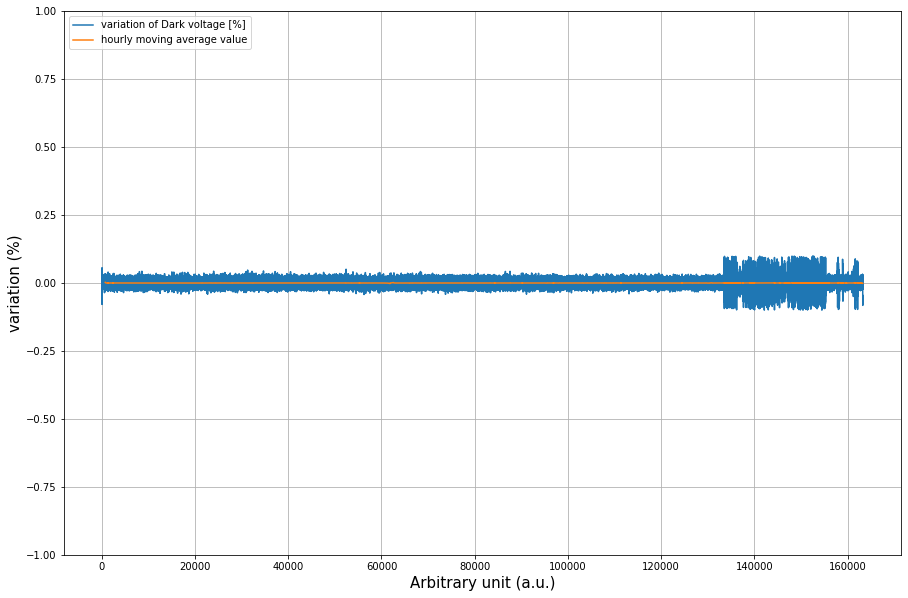

In [81]:
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(df4['Vd_corr_%change'],label='variation of Dark voltage [%]')
plt.plot(df4['avg_Vd_corr%change'],label='hourly moving average value')
plt.legend(loc=2)
plt.xlabel('Arbitrary unit (a.u.)',fontsize=15)
plt.ylabel('variation (%)',fontsize=15)
plt.ylim(-1,1)
# plt.savefig('letid_data_BDT_20201211_filtered_plot_2.jpeg')
plt.show()